In [1]:
import torch
from skimage import data
import matplotlib.pyplot as plt
import seaborn as sns
import clip
from PIL import Image
from torchvision.datasets import CIFAR100
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available() and torch.cuda.get_device_capability() == (8, 9):
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cuda.matmul.allow_tf32 = True

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
images_func = [data.astronaut, data.cat, data.coffee, data.colorwheel, data.hubble_deep_field, data.immunohistochemistry, data.retina]

images = []
descriptions = ['astronaut', 'cat', 'coffee', 'colorwheel', 'hub_deep_field', 'immunohistochemistry', 'retina']

for img_func in images_func:
    image = img_func()
    image = Image.fromarray(image)
    images.append(preprocess(image).unsqueeze(0).to(device))

In [4]:
image_features = torch.cat([model.encode_image(image) for image in images])

text_inputs = torch.cat([clip.tokenize(desc) for desc in descriptions]).to(device)
text_features = model.encode_text(text_inputs)

C:\Users\sasha\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [5]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = (image_features @ text_features.T).cpu().detach().numpy()

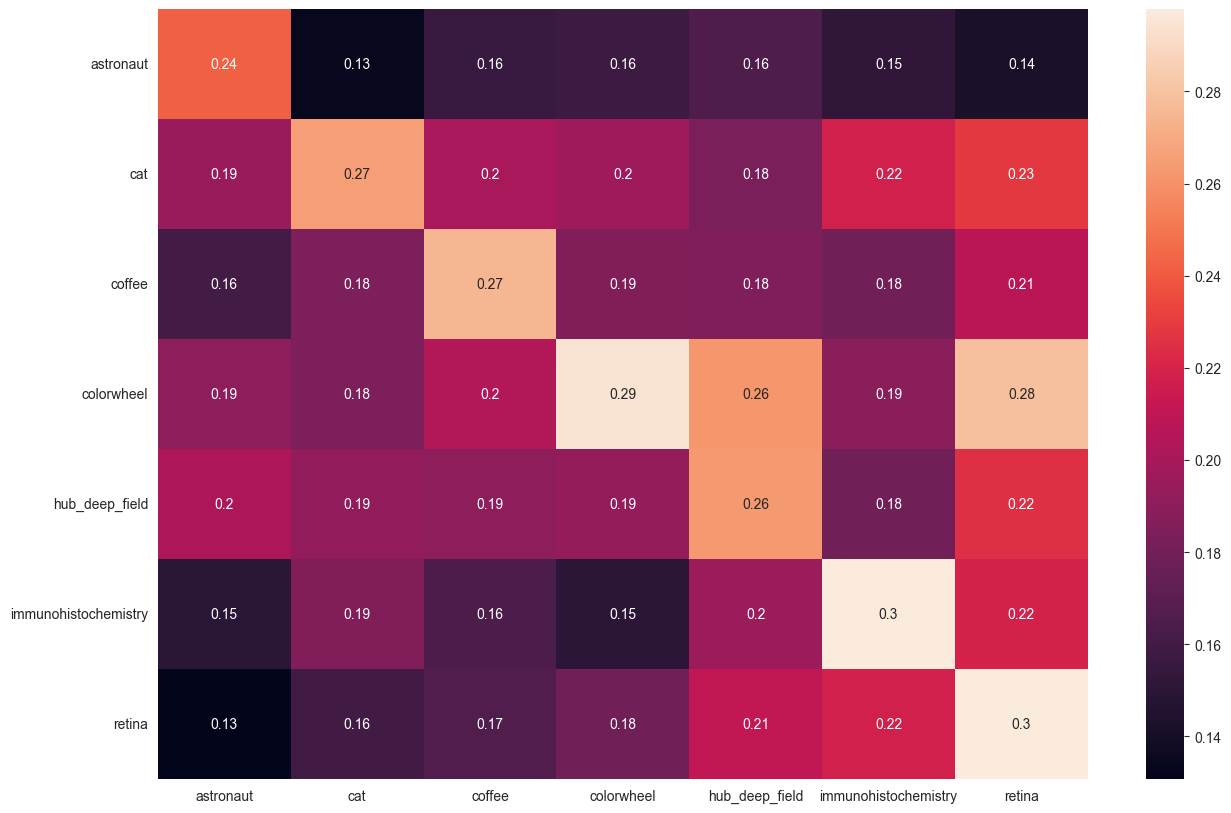

In [6]:
plt.figure(figsize=(15, 10))
sns.heatmap(similarity, xticklabels=descriptions, yticklabels=descriptions, annot=True)
plt.show()

In [7]:
cifar100 = CIFAR100(root="./Datasets", download=True)
class_names = cifar100.classes

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in class_names]).to(device)
text_features = model.encode_text(text_inputs)

text_features /= text_features.norm(dim=-1, keepdim=True)

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Files already downloaded and verified


In [8]:
for desc, img_func in zip(descriptions, images_func):
    image = img_func()
    image = Image.fromarray(image)
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    similarity = (image_features @ text_features.T).softmax(dim=-1).cpu().detach().numpy()

    top_indices = similarity[0].argsort()[-5:][::-1]
    top_probs = similarity[0][top_indices]
    top_labels = [class_names[i] for i in top_indices]

    print(f"Top matches for '{desc}':")
    for prob, label in zip(top_probs, top_labels):
        print(f"  {label}: {prob:.4f}")
    print()

Top matches for 'astronaut':
  woman: 0.0109
  girl: 0.0106
  rocket: 0.0105
  plain: 0.0104
  baby: 0.0104

Top matches for 'cat':
  sweet_pepper: 0.0106
  boy: 0.0104
  tiger: 0.0104
  girl: 0.0104
  baby: 0.0104

Top matches for 'coffee':
  cup: 0.0109
  plate: 0.0105
  bowl: 0.0105
  table: 0.0105
  plain: 0.0105

Top matches for 'colorwheel':
  plate: 0.0106
  plain: 0.0105
  lamp: 0.0105
  apple: 0.0104
  bowl: 0.0104

Top matches for 'hub_deep_field':
  plain: 0.0106
  plate: 0.0106
  bowl: 0.0105
  table: 0.0104
  wardrobe: 0.0104

Top matches for 'immunohistochemistry':
  sunflower: 0.0104
  pine_tree: 0.0103
  mushroom: 0.0103
  poppy: 0.0103
  worm: 0.0102

Top matches for 'retina':
  plate: 0.0105
  orange: 0.0105
  apple: 0.0105
  poppy: 0.0105
  television: 0.0104

